In [1]:
%load_ext autotime

time: 293 µs (started: 2021-10-31 13:51:02 +00:00)


In [2]:
import warnings
warnings.filterwarnings("ignore")

time: 389 µs (started: 2021-10-31 13:51:02 +00:00)


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

time: 213 ms (started: 2021-10-31 13:51:02 +00:00)


In [4]:
train = pd.read_parquet('../data/processed/df_train.parquet')
test = pd.read_parquet('../data/processed/df_test.parquet')
test.loc[test['date'] == test['date'].min(), 'price_change_perc'] = 0
test.loc[test['date'] == test['date'].min(), 'price_change_logdiff'] = 0

sub = pd.read_csv('../data/raw/sample_final.csv')

time: 2.1 s (started: 2021-10-31 13:51:02 +00:00)


In [5]:
cols = ['geo_cluster_id', 'sku_id', 'date', 'price', 'sales', 'city_id', 
        'category_id', 'product_type_id', 'brand_id', 'trademark_id',
        'origin_country_id', 'commodity_group_id', 'weekday', 'price_change_perc']

def transform_df(df, max_days=100):
    df = df[df['date'] > df['date'].max() - timedelta(days=max_days)]
    df = df[cols].copy()
    df['price_change'] = df['price_change_perc'] !=0
    return df.drop(columns= 'price_change_perc').fillna(0)

train = transform_df(train)
test = transform_df(test)

train

,geo_cluster_id,sku_id,date,price,sales,city_id,category_id,product_type_id,brand_id,trademark_id,origin_country_id,commodity_group_id,weekday,price_change
transaction_id,,,,,,,,,,,,,,
28034500,1990,17,2021-04-11,52.59,0.0,0,5416,4770,-1,-1,-1,5551018,6,False
28034501,1990,17,2021-04-12,52.59,0.0,0,5416,4770,-1,-1,-1,5551018,0,False
28034502,1990,17,2021-04-13,52.59,0.0,0,5416,4770,-1,-1,-1,5551018,1,False
28034503,1990,17,2021-04-14,52.59,0.0,0,5416,4770,-1,-1,-1,5551018,2,False
28034504,1990,17,2021-04-15,52.59,0.0,0,5416,4770,-1,-1,-1,5551018,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42797611,3209,873803,2021-07-15,0.00,0.0,0,5923,697,-1,2779,-1,5550259,3,False
42797612,3209,873803,2021-07-16,0.00,0.0,0,5923,697,-1,2779,-1,5550259,4,False
42797613,3209,873803,2021-07-17,0.00,0.0,0,5923,697,-1,2779,-1,5550259,5,False


time: 2.13 s (started: 2021-10-31 13:51:04 +00:00)


# Features

In [6]:
geo_sku_date_cols = ['geo_cluster_id', 'sku_id', 'date']
source_feature_cols = ['price_change', 'sales', 'price', 'weekday']


def get_future_values(df, date, col, n=14):
    cols = geo_sku_date_cols + [col]
    df_roll = df.loc[(df['date'] <= date + timedelta(days=n)) & (df['date'] >= date) ,cols].copy()
    for i in range(1, n+1):
        df_roll[f'{col}_{i}'] = df_roll[col].shift(-i)

    geo_cluster_mask = df_roll['geo_cluster_id'] == df_roll['geo_cluster_id'].shift(-n)
    sku_id_mask = df_roll['sku_id'] == df_roll['sku_id'].shift(-n)
    
    df_roll = df_roll[geo_cluster_mask & sku_id_mask].dropna().drop(columns=col)
    
    roll_cols = [f'{col}_{i}' for i in range(1, n+1)]
    df_roll[roll_cols] = df_roll[roll_cols].astype(df[col].dtype)
    return df_roll


def get_feature(df, date, train_days=30):
    df = df[(date >= df['date']) & (df['date'] > date - timedelta(days=train_days))]
    
    group_name_list = [
        (['geo_cluster_id', 'sku_id'], 'median_geo_sku'),
        (['geo_cluster_id', 'sku_id', 'weekday'], 'median_geo_sku_weekday'),
        (['geo_cluster_id'], 'median_geo_cluster_id'),
        (['sku_id'], 'median_sku_id'),
        (['city_id'], 'median_city_id'),
        (['category_id'], 'median_category_id'),
        (['product_type_id'], 'median_product_type_id'),
        (['brand_id'], 'median_brand_id'),
        (['trademark_id'], 'median_trademark_id'),
        (['origin_country_id'], 'median_origin_country_id'),
        (['commodity_group_id'], 'median_commodity_group_id'),
    ]
    
    median_feature = [
        df[df['sales']!=0].groupby(['geo_cluster_id', 'sku_id'])['sales'].median().rename('median_non_zero_sales'),
        df[df['price_change']!=0].groupby(['geo_cluster_id', 'sku_id'])['sales'].median().rename('median_price_change_sales'),
        df[df['price_change']==0].groupby(['geo_cluster_id', 'sku_id'])['sales'].median().rename('median_no_price_change_sales'),
    ]
    result = pd.concat(median_feature, axis=1).fillna(0)
    result['date'] = date
    result = result.merge(df, on=geo_sku_date_cols, how='left')
    
    for group, name in group_name_list:
        group_results = df.groupby(group)['sales'].median().rename(name)
        result = result.merge(group_results, on=group, how='left')
    
    cols = geo_sku_date_cols + \
            source_feature_cols + \
            ['median_non_zero_sales', 'median_price_change_sales', 'median_no_price_change_sales'] +\
            [name for _, name in group_name_list]
    
    return result[cols].reset_index(drop=True)

def get_df(df, date, get_targets=True):
    feature = get_feature(df , date, train_days=30)
    price_change = get_future_values(df , date, 'price_change')
    result = feature.merge(price_change, on=geo_sku_date_cols)
    
    if get_targets:
        target = get_future_values(df , date, 'sales')
        result = result.merge(target, on=geo_sku_date_cols)
        
    return result

time: 10 ms (started: 2021-10-31 13:51:06 +00:00)


# CV

In [7]:
train_days = 30
valid_days = 14

train_end_date = train['date'].max()
valid_end_date_list = [train_end_date - timedelta(days=int(days)) for days in np.arange(valid_days, 45, step=7)]

train_list = [get_df(train, date - timedelta(days=train_days)) for date in valid_end_date_list]
valid_list = [get_df(train, date) for date in valid_end_date_list]

valid_end_date_list

[Timestamp('2021-07-05 00:00:00'),
 Timestamp('2021-06-28 00:00:00'),
 Timestamp('2021-06-21 00:00:00'),
 Timestamp('2021-06-14 00:00:00'),
 Timestamp('2021-06-07 00:00:00')]

time: 52.4 s (started: 2021-10-31 13:51:06 +00:00)


# Train

In [8]:
from lightgbm.sklearn import LGBMRegressor

def edit_valid_price_change(df):
    df = df.copy()
    price_change_df = np.array(df[price_change_cols])
    target_df = np.array(df[target_cols] > 0)
    price_change_df[np.arange(target_df.shape[0]), target_df.argmax(axis=1)] = True
    df[price_change_cols] = price_change_df
    df['price_change_1'] = False
    
    df.loc[~df[target_cols].any(axis=1), price_change_cols] = False
    
    return df

def metric(target, predict):
    return (target - predict).abs().sum()/target.sum()


train_cols = ['price_change', 'sales', 'price', 'weekday', 
              'median_non_zero_sales', 'median_price_change_sales', 'median_no_price_change_sales', 'median_geo_sku',
              'median_geo_sku_weekday', 'median_geo_cluster_id', 'median_sku_id', 'median_city_id', 'median_category_id', 
              'median_product_type_id', 'median_brand_id', 'median_trademark_id', 'median_origin_country_id', 'median_commodity_group_id']

price_change_cols = [f'price_change_{i}' for i in range(1,15)]
target_cols = [f'sales_{i}' for i in range(1,15)]
target2price_change = dict(zip(target_cols, price_change_cols))

time: 263 ms (started: 2021-10-31 13:51:58 +00:00)


In [9]:
results = pd.DataFrame(index=range(len(train_list)), columns=target_cols)
best_iter = pd.DataFrame(index=range(len(train_list)), columns=target_cols)

for i, (fold_train, fold_valid) in enumerate(zip(train_list, valid_list)):
    for target_col in tqdm(target_cols):
        model_train_cols = train_cols + [target2price_change[target_col]]
        
        model = LGBMRegressor(num_leaves=31, max_depth=8, learning_rate=0.1, n_estimators=999, boosting_type='gbdt', objective='mae', random_state=42)
        model.fit(fold_train[model_train_cols], 
               fold_train[target_col], 
               eval_set=[(fold_valid[model_train_cols], 
                          fold_valid[target_col])], 
               early_stopping_rounds=10,
               verbose=0
              )    
        pred = model.predict(edit_valid_price_change(fold_valid)[model_train_cols])
        
        results.loc[i, target_col] = metric(fold_valid[target_col], pred)
        best_iter.loc[i, target_col] = model.best_iteration_
    
        
print('public:', results[['sales_1', 'sales_2', 'sales_3', 'sales_4', 'sales_5', 'sales_6', 'sales_7']].mean().mean())
print('private:', results[['sales_8', 'sales_9', 'sales_10', 'sales_11', 'sales_12', 'sales_13', 'sales_14']].mean().mean())
print('mean iter:', best_iter.mean().mean(), '\n')
print('fold mean:\n', pd.DataFrame(results.mean(axis=1), columns=['']).T, '\n')
print('day mean:\n', pd.DataFrame(results.mean(axis=0), columns=['']).T, '\n')
results

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

public: 0.7384205911767825
private: 0.7938083872270975
mean iter: 52.41428571428571 

fold mean:
          0        1        2         3         4
  0.761616  0.76624  0.77299  0.766891  0.762836 

day mean:
    sales_1   sales_2   sales_3   sales_4  sales_5   sales_6   sales_7  \
  0.910059  0.625048  0.646549  0.710965  0.74012  0.759432  0.776769   

  sales_8   sales_9  sales_10  sales_11  sales_12  sales_13  sales_14  
  0.79223  0.798499  0.751749  0.787627   0.79823  0.810556  0.817767   



,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14
0,0.90725,0.61836,0.651364,0.690566,0.718846,0.746651,0.765956,0.791944,0.785799,0.768789,0.787617,0.797493,0.809615,0.822372
1,0.90642,0.636956,0.65967,0.724031,0.749702,0.773055,0.785142,0.787943,0.793883,0.756912,0.769588,0.78012,0.798533,0.805411
2,0.905099,0.621104,0.627417,0.733127,0.752879,0.763475,0.77628,0.79453,0.820722,0.762533,0.802564,0.811604,0.822482,0.828037
3,0.920177,0.632694,0.656622,0.711239,0.740496,0.766335,0.782272,0.790799,0.789187,0.716802,0.799641,0.805095,0.80936,0.815749
4,0.911348,0.616129,0.637674,0.695864,0.738679,0.747647,0.774195,0.795937,0.802903,0.753709,0.778726,0.796837,0.812793,0.817265


time: 49.4 s (started: 2021-10-31 13:51:59 +00:00)


# Fix N Iter

In [10]:
results = pd.DataFrame(index=range(len(train_list)), columns=target_cols)
n_iter = best_iter.mean().mean().round().astype(int)

for i, (fold_train, fold_valid) in enumerate(zip(train_list, valid_list)):
    for target_col in tqdm(target_cols):
        model_train_cols = train_cols + [target2price_change[target_col]]
        
        model = LGBMRegressor(num_leaves=31, max_depth=8, learning_rate=0.1, n_estimators=n_iter, boosting_type='gbdt', objective='mae', random_state=42)
        model.fit(fold_train[model_train_cols], fold_train[target_col])    
        pred = model.predict(edit_valid_price_change(fold_valid)[model_train_cols])
        
        results.loc[i, target_col] = metric(fold_valid[target_col], pred)
    
        
print('public:', results[['sales_1', 'sales_2', 'sales_3', 'sales_4', 'sales_5', 'sales_6', 'sales_7']].mean().mean())
print('private:', results[['sales_8', 'sales_9', 'sales_10', 'sales_11', 'sales_12', 'sales_13', 'sales_14']].mean().mean())
print('mean iter:', best_iter.mean().mean(), '\n')
print('fold mean:\n', pd.DataFrame(results.mean(axis=1), columns=['']).T, '\n')
print('day mean:\n', pd.DataFrame(results.mean(axis=0), columns=['']).T, '\n')
results

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

public: 0.7400031201618373
private: 0.7950916572864387
mean iter: 52.41428571428571 

fold mean:
          0         1         2        3         4
  0.762579  0.767368  0.774008  0.76919  0.764592 

day mean:
    sales_1   sales_2   sales_3   sales_4   sales_5   sales_6   sales_7  \
  0.911992  0.630639  0.647439  0.711438  0.741096  0.759993  0.777425   

   sales_8   sales_9  sales_10  sales_11  sales_12  sales_13  sales_14  
  0.793875  0.802052  0.752794  0.788373  0.798657  0.811231  0.818659   



,sales_1,sales_2,sales_3,sales_4,sales_5,sales_6,sales_7,sales_8,sales_9,sales_10,sales_11,sales_12,sales_13,sales_14
0,0.907197,0.619446,0.653021,0.691027,0.718846,0.747098,0.765956,0.792593,0.786293,0.772273,0.789691,0.798522,0.810017,0.824121
1,0.906417,0.645387,0.66082,0.724589,0.74981,0.773314,0.78558,0.788114,0.794878,0.757078,0.770183,0.78058,0.800602,0.805799
2,0.907248,0.624452,0.628097,0.733201,0.753836,0.764798,0.77734,0.795179,0.823278,0.762968,0.802631,0.811722,0.823029,0.82833
3,0.927697,0.647636,0.656872,0.711471,0.743411,0.766603,0.78248,0.792058,0.79184,0.717208,0.800143,0.805296,0.809629,0.816318
4,0.9114,0.616271,0.638388,0.696903,0.739576,0.748151,0.775766,0.801431,0.813971,0.754443,0.779219,0.797164,0.812878,0.818728


time: 36 s (started: 2021-10-31 13:52:48 +00:00)


# predict

In [11]:
test_train = get_df(train, train_end_date-timedelta(days=14))
test_test = get_df(test.append(train).sort_values(['geo_cluster_id', 'sku_id', 'date']), train_end_date, get_targets=False)
n_iter = best_iter.mean().mean().round().astype(int)

test_predictions = []
for target_col, date in zip(tqdm(target_cols), np.sort(test['date'].unique())):
    model_train_cols = train_cols + [target2price_change[target_col]]
    
    model = LGBMRegressor(num_leaves=31, max_depth=8, learning_rate=0.1, n_estimators=n_iter, boosting_type='gbdt', objective='mae', random_state=42)
    model.fit(test_train[model_train_cols], test_train[target_col])
    model_prediction = model.predict(test_test[model_train_cols])
    
    pred = test_test[['geo_cluster_id', 'sku_id']].copy()
    pred['date'] = date
    pred['pred'] = model_prediction
    test_predictions.append(pred)
    
test_predictions = pd.concat(test_predictions).reset_index(drop=True)

  0%|          | 0/14 [00:00<?, ?it/s]

time: 22.5 s (started: 2021-10-31 13:53:24 +00:00)


In [12]:
sub = pd.read_csv('../data/raw/sample_final.csv')
test_predicted = test.merge(test_predictions, on=['geo_cluster_id', 'sku_id', 'date'], how='left').fillna(0)
sub['sales'] = test_predicted['pred'].tolist()
sub.loc[sub['sales'] < 0, 'sales'] = 0
sub['sales'].mean()

0.07994718013530125

time: 1.4 s (started: 2021-10-31 13:53:47 +00:00)


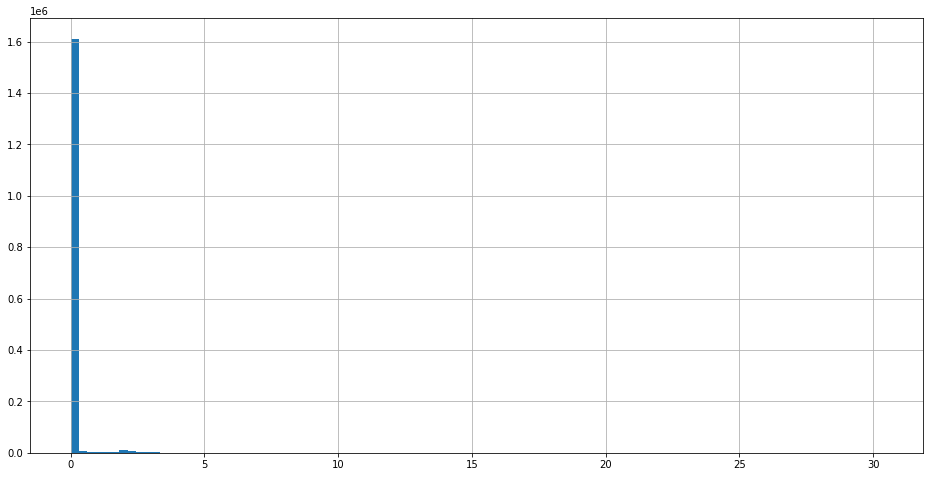

time: 2.74 s (started: 2021-10-31 13:53:48 +00:00)


In [13]:
sub.to_csv('../submissions/sub_TimeCV_DayModels_Id2Median_PriceChangeFeature.csv', index=False)
sub['sales'].hist(bins=100, figsize=(16,8));